In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from importlib import reload
import util 
reload(util)
from util import get_MNIST_loaders, train_model, plot_accuracy, plot_training_loss

# Convolutional Neural Networks
## LeNet-5

![LeNet-5](img/LeNet5-architecture.png)
*Source: Original paper available at: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf*

In [2]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes, greyscale):
        super(LeNet5, self).__init__()
        self.greyscale = greyscale
        if greyscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        features = torch.flatten(features, 1)
        logits = self.classifier(features)
        return logits

## LeNet5 on MNIST

In [3]:
# Architecture
num_classes = 10

# Hyperparameters
learning_rate = 0.1
batch_size = 256
num_epochs = 15
random_seed = 0

data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_loader, valid_loader, test_loader = get_MNIST_loaders(
    batch_size=batch_size,
    transform=data_transform
)

In [4]:
import time
torch.manual_seed(random_seed)
model = LeNet5(num_classes, greyscale=True)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.1, 
    mode='max', 
    verbose=True
)
loss_fn = torch.nn.CrossEntropyLoss()

minibatch_loss, train_acc, valid_acc = train_model(
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    loss_fn=loss_fn, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    test_loader=test_loader, 
    num_epochs=num_epochs, 
    batch_size=batch_size
)

Epoch: 001/015 | Batch 000/256 | Cost: 2.3000
Epoch: 001/015 | Batch 050/256 | Cost: 1.2159
Epoch: 001/015 | Batch 100/256 | Cost: 0.4384
Epoch: 001/015 | Batch 150/256 | Cost: 0.3543
Time elapsed: 0.28 min
Epoch: 001/015 Train: 92.16% | Validation: 92.47%
Epoch: 002/015 | Batch 000/256 | Cost: 0.3002
Epoch: 002/015 | Batch 050/256 | Cost: 0.2324
Epoch: 002/015 | Batch 100/256 | Cost: 0.2159
Epoch: 002/015 | Batch 150/256 | Cost: 0.1976
Time elapsed: 0.76 min
Epoch: 002/015 Train: 95.75% | Validation: 95.95%
Epoch: 003/015 | Batch 000/256 | Cost: 0.1251
Epoch: 003/015 | Batch 050/256 | Cost: 0.1198
Epoch: 003/015 | Batch 100/256 | Cost: 0.1095
Epoch: 003/015 | Batch 150/256 | Cost: 0.0676
Time elapsed: 1.20 min
Epoch: 003/015 Train: 96.90% | Validation: 96.84%
Epoch: 004/015 | Batch 000/256 | Cost: 0.1567
Epoch: 004/015 | Batch 050/256 | Cost: 0.1172
Epoch: 004/015 | Batch 100/256 | Cost: 0.0634
Epoch: 004/015 | Batch 150/256 | Cost: 0.1271
Time elapsed: 1.66 min
Epoch: 004/015 Train: 

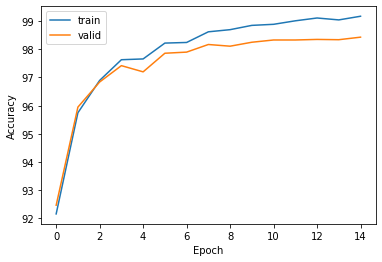

In [20]:
plot_accuracy(train_acc, valid_acc)

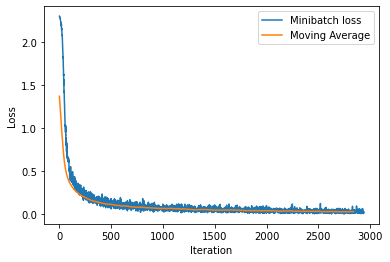

In [21]:
plot_training_loss(minibatch_loss)